In [16]:
#dependencies
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
from pptx import Presentation
import pptx.util
import imageio
import imutils
from skimage.filters import threshold_local

In [26]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    return cv2.warpPerspective(image, M, (maxWidth, maxHeight))

In [27]:
input_folder = "./input"
intermediate_results = "./output"
output_file = "./my_slides.pptx"

In [28]:
SUPPORTED_FORMATS = (".BMP", ".DIB", ".JPEG", ".JPG", ".JPE", ".JP2", ".PNG", ".WEBP", ".PBM", ".PGM", ".PPM", ".SR", ".RAS", ".TIFF", ".TIF") #tuple
def isImage(filename):
    return filename.upper().endswith(SUPPORTED_FORMATS)

In [29]:
#make ordered list of image files files in input folder
only_files = [f for f in listdir(input_folder) if isfile(join(input_folder, f))]
only_files.sort()
only_images = list(filter(lambda x: isImage(x), only_files))
only_images

['IMG_8554.JPG',
 'IMG_8555.JPG',
 'IMG_8556.JPG',
 'IMG_8557.JPG',
 'IMG_8559.JPG']

In [30]:
TARGET_SIZE = 500
images = []
edges = []
originals = []

for image in only_images:
    relative_path = input_folder + "/" + image
    print("processing: " + relative_path)
    image = cv2.imread(relative_path)
    original = image.copy()
    ratio = image.shape[0] / TARGET_SIZE
    image = imutils.resize(image, height = TARGET_SIZE)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(image,(5,5),0)
    edge = cv2.Canny(blur, 75, 200)
    kernel = np.ones((5,5),np.uint8)
    edge = cv2.dilate(edge,kernel,iterations = 1)    
    images.append(image)
    edges.append(edge)
    originals.append(original)
    
print("small images: " + str(len(images)))
print("color images: " + str(len(originals)))
print("edge images: " + str(len(edges)))

processing: ./input/IMG_8554.JPG


error: OpenCV(3.4.4) /io/opencv/modules/imgproc/src/clahe.cpp:351: error: (-215:Assertion failed) _src.type() == CV_8UC1 || _src.type() == CV_16UC1 in function 'apply'


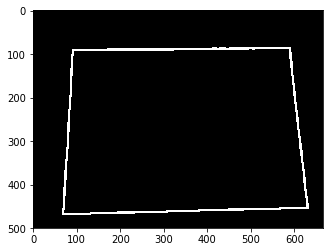

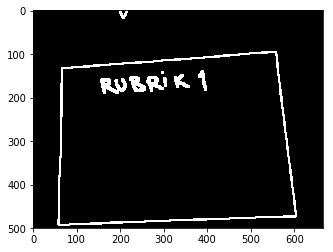

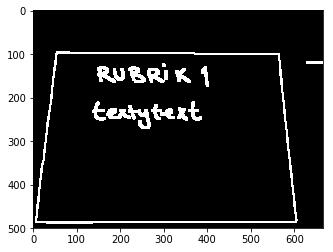

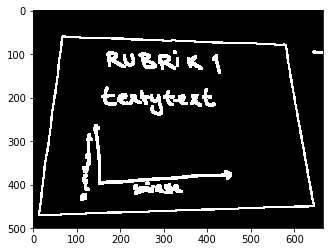

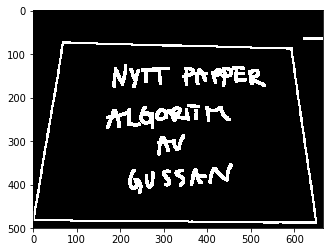

In [22]:
cnt_images = []
for idx in range(len(edges)):
    plt.imshow(edges[idx], 'gray'),plt.show()
    # find the contours in the edged image, keeping only the
    # largest ones, and initialize the screen contour
    cnts = cv2.findContours(edges[idx].copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
    # loop over the contours
    for cnt in cnts:
        # approximate the contour
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.05 * peri, True)

        # if our approximated contour has four points, then we
        # can assume that we have found our screen
        if len(approx) == 4:
            screenCnt = approx
            cnt_images.append(screenCnt)
            break


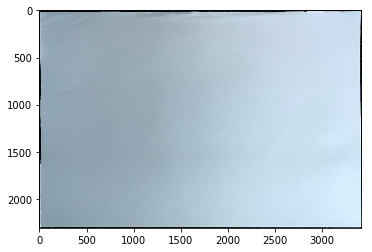

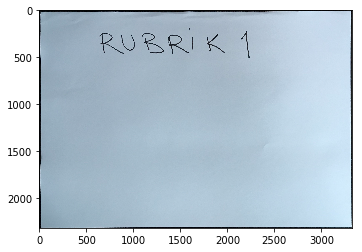

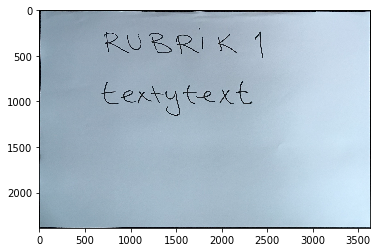

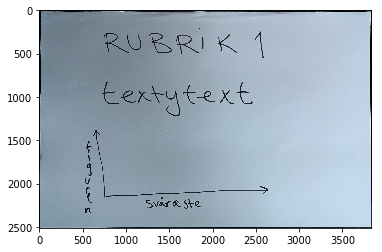

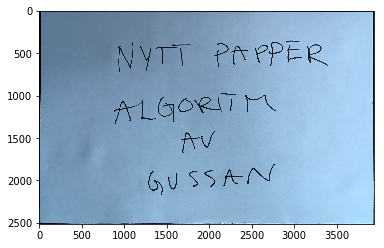

In [24]:
for idx in range(len(originals)):
    warped = four_point_transform(originals[idx], cnt_images[idx].reshape(4, 2) * ratio)
    cv2.imwrite(intermediate_results + "/" + only_images[idx] , warped)

    plt.imshow(warped),plt.show()

In [25]:
#strech each image to a new slide. Proportions of slide will be keept.
prs = Presentation()
BLANK_SLIDE = prs.slide_layouts[6]
# default slide width
#prs.slide_width = 9144000
# slide height @ 4:3
#prs.slide_height = 6858000
# slide height @ 16:9
#prs.slide_height = 5143500
slideAspectRatio = prs.slide_width/prs.slide_height
for image in only_images:
    relative_path = intermediate_results + "/" + image
    slide = prs.slides.add_slide(BLANK_SLIDE)
    shapes = slide.shapes
    picture = shapes.add_picture(relative_path, 0, 0, prs.slide_width, prs.slide_height)
    
prs.save(output_file)